In [ ]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [ ]:
import folium
from folium import plugins

## Import and check data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/train_data (1).csv')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/train_data (1).csv')
valid = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/valid.csv')

## Check geography
География точек - СПБ, ЛенОбласть

In [ ]:
stats = valid.groupby(['lon','lat'])['hour'].count().reset_index().sort_values('hour')

In [ ]:
m = folium.Map(location=(59.93863, 30.31413), tiles=None, zoom_start=6)

folium.TileLayer("openstreetmap").add_to(m)

figure_both = folium.FeatureGroup(name="Метка на обеих картах").add_to(m)

icon_red = folium.Icon(color="red")

for coords in stats[['lat','lon']].values:
  folium.Marker(tuple(coords), tooltip='mark').add_to(figure_both)

folium.LayerControl(collapsed=False).add_to(m)

m

In [ ]:
## train extreme coords

In [ ]:
stats = train.groupby(['lon','lat'])['timestamp'].count().reset_index().sort_values('timestamp')

In [ ]:
stats = stats.query('lat<59|lat>61|lon<29|lon>31')

In [ ]:
m = folium.Map(location=(59.93863, 30.31413), tiles=None, zoom_start=6)

folium.TileLayer("openstreetmap").add_to(m)

figure_both = folium.FeatureGroup(name="Метка на обеих картах").add_to(m)

icon_red = folium.Icon(color="red")

for coords in stats[['lat','lon']].values:
  folium.Marker(tuple(coords), tooltip='mark').add_to(figure_both)

folium.LayerControl(collapsed=False).add_to(m)

m

## Build train sample

In [ ]:
#trainset = train.copy()
short_trainset = train[['lon','lat','point']].drop_duplicates()
short_trainset.to_csv('short_trainset.csv')

In [ ]:
short_trainset.head()

,timestamp,lon,lat,point
0,1565607600,30.329370,59.940488,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,0101000020E6100000268147F5244F3E40494A4ED65FF7...


### Check relation point-coords

In [ ]:
short_trainset['coords'] = short_trainset['lon'].astype('str')+'-'+short_trainset['lat'].astype('str')

In [ ]:
# check relation point-coords
short_trainset.groupby(['point'])['coords'].nunique().reset_index(name='count').sort_values('count')

,point,count
0,0101000020E61000000000000000000000000000000000...,1
4699,0101000020E6100000AC1A327F9D6D3E408FAA9F16E404...,1
4698,0101000020E6100000AC1A327F9D6D3E407916A554F5F8...,1
4697,0101000020E6100000AC1A327F9D6D3E4074DD5BB2DBED...,1
4696,0101000020E6100000AC1A327F9D6D3E406E4CE6811AEA...,1
...,...,...
2341,0101000020E6100000544263A8C4573E40516FA59DABF8...,1
2340,0101000020E6100000544263A8C4573E405009D46AD3EA...,1
2339,0101000020E6100000544263A8C4573E404983611E77F1...,1
2350,0101000020E6100000544263A8C4573E407F614299EAF3...,1


In [ ]:
short_trainset = short_trainset.drop(['coords'],1)

### Check coords
* nice lat 59-61
* nice lon 29-31

In [ ]:
nice_short_trainset = short_trainset.query('lat>59&lat<61&lon>29&lon<31')

In [ ]:
nice_short_trainset['publication'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
nice_short_trainset.head(1)

,timestamp,lon,lat,point,publication
0,1565607600,30.32937,59.940488,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,1


### Build short set

In [ ]:
nice_grouped = nice_short_trainset.groupby(['point','lat','lon','timestamp']).count().reset_index()

In [ ]:
nice_grouped

,point,lat,lon,timestamp,publication
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574420400,1
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574424000,1
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574514000,1
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574697600,1
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574848800,1
...,...,...,...,...,...
3625575,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,59.898840,30.522508,1575604800,2
3625576,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,59.898840,30.522508,1577088000,1
3625577,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,59.870670,30.522508,1560157200,1
3625578,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,59.870670,30.522508,1570370400,1


In [ ]:
nice_grouped.to_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/nice_grouped.csv', index=False)

In [ ]:
nice_grouped

,point,lat,lon,timestamp,publication
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574420400,1
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574424000,1
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574514000,1
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574697600,1
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574848800,1
...,...,...,...,...,...
3625575,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,59.898840,30.522508,1575604800,2
3625576,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,59.898840,30.522508,1577088000,1
3625577,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,59.870670,30.522508,1560157200,1
3625578,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,59.870670,30.522508,1570370400,1


### Feature Engineering

In [ ]:
from datetime import datetime

In [ ]:
short_train = pd.read_csv('nice_grouped.csv').drop(['point'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
short_train.head()

,lat,lon,timestamp,publication
0,59.835705,30.11602,1574420400,1
1,59.835705,30.11602,1574424000,1
2,59.835705,30.11602,1574514000,1
3,59.835705,30.11602,1574697600,1
4,59.835705,30.11602,1574848800,1


In [ ]:
short_train['date'] = pd.to_datetime(short_train['timestamp'], unit='s')

In [ ]:
short_train.head(3)

,lat,lon,timestamp,publication,date
0,59.835705,30.11602,1574420400,1,2019-11-22 11:00:00
1,59.835705,30.11602,1574424000,1,2019-11-22 12:00:00
2,59.835705,30.11602,1574514000,1,2019-11-23 13:00:00


In [ ]:
short_train['hour'] = short_train['date'].apply(lambda x: x.hour)
short_train['day'] = short_train['date'].apply(lambda x: x.day)
short_train['month'] = short_train['date'].apply(lambda x: x.month)

In [ ]:
short_train.head(3)

,lat,lon,timestamp,publication,date,hour,day,month
0,59.835705,30.11602,1574420400,1,2019-11-22 11:00:00,11,22,11
1,59.835705,30.11602,1574424000,1,2019-11-22 12:00:00,12,22,11
2,59.835705,30.11602,1574514000,1,2019-11-23 13:00:00,13,23,11


In [ ]:
short_train.to_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/nice_train_on_baseline.csv', index=False)
short_train.head()

,lat,lon,timestamp,publication,date,hour,day,month
0,59.835705,30.11602,1574420400,1,2019-11-22 11:00:00,11,22,11
1,59.835705,30.11602,1574424000,1,2019-11-22 12:00:00,12,22,11
2,59.835705,30.11602,1574514000,1,2019-11-23 13:00:00,13,23,11
3,59.835705,30.11602,1574697600,1,2019-11-25 16:00:00,16,25,11
4,59.835705,30.11602,1574848800,1,2019-11-27 10:00:00,10,27,11


### Baseline XGBOOST

In [ ]:
short_train = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/nice_train_on_baseline.csv')

In [ ]:
short_train.head()

,lat,lon,timestamp,publication,date,hour,day,month
0,59.835705,30.11602,1574420400,1,2019-11-22 11:00:00,11,22,11
1,59.835705,30.11602,1574424000,1,2019-11-22 12:00:00,12,22,11
2,59.835705,30.11602,1574514000,1,2019-11-23 13:00:00,13,23,11
3,59.835705,30.11602,1574697600,1,2019-11-25 16:00:00,16,25,11
4,59.835705,30.11602,1574848800,1,2019-11-27 10:00:00,10,27,11


In [ ]:
short_train_no_date = short_train.drop(['date','timestamp'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
short_train_no_date.head(2)

,lat,lon,publication,hour,day,month
0,59.835705,30.11602,1,11,22,11
1,59.835705,30.11602,1,12,22,11


In [ ]:
valid.head(2)

,hour,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291


In [ ]:
short_train_no_date = short_train_no_date[['lat', 'lon', 'hour', 'day', 'month','publication']]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(short_train_no_date.drop(['publication'],1), short_train_no_date.publication, train_size=0.8, random_state=69)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
out_of_sample = valid.copy().rename(columns={'sum':'publication'})

out_of_sample['date'] = pd.to_datetime(out_of_sample['hour'], unit='s')
out_of_sample['hour'] = out_of_sample['date'].apply(lambda x: x.hour)
out_of_sample['day'] = out_of_sample['date'].apply(lambda x: x.day)
out_of_sample['month'] = out_of_sample['date'].apply(lambda x: x.month)

out_of_sample = out_of_sample[['lat', 'lon', 'hour', 'day', 'month','publication']]

X_test, y_test = out_of_sample.drop(['publication'],1), out_of_sample.publication

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
baseline_model = XGBRegressor()

In [ ]:
baseline_model.fit(X_train, y_train)

valid_preds = baseline_model.predict(X_valid)
test_preds = baseline_model.predict(X_test)

[13:21:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
def custom_loss(true_val, pred_val):
  return abs(pred_val-true_val)/pred_val

In [ ]:
custom_loss(y_valid, valid_preds)

2613679    0.107149
1629317    0.383179
27046      0.730334
1159044    0.638955
484636     0.086935
             ...   
1332147    0.493939
3379687    0.960796
1806687    0.652208
1531392    0.431063
2774439    0.411860
Name: publication, Length: 725116, dtype: float64

In [ ]:
print('VALID: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_valid, valid_preds),
                                                         mse(y_valid, valid_preds),
                                                         r2(y_valid, valid_preds),
                                                         np.mean(custom_loss(y_valid, valid_preds))))

print('TEST: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_test, test_preds),
                                                         mse(y_test, test_preds),
                                                         r2(y_test, test_preds),
                                                         np.mean(custom_loss(y_test, test_preds))))

VALID: mae 1.5863632178708735, mse 15.866827719482592, r2 0.13601475085158354, custom_loss 0.6062896055959267
TEST: mae 6.753881596375588, mse 80.40013458632382, r2 -0.9608568259276771, custom_loss 2.3752464439204886


In [ ]:
valid

,hour,lat,lon,point,sum,error,baseline_error,baseline_pred
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402,0.952273,2.561118
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291,0.764835,7.932751
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735,1.927986,1.707658
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735,1.267667,3.086872
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735,0.993956,7.021219
...,...,...,...,...,...,...,...,...
704,1580659200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735,2.968586,1.763852
705,1581048000,59.950610,30.315895,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735,0.855609,4.311253
706,1581656400,59.933737,30.309158,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735,1.038598,2.943200
707,1580724000,59.931487,30.358565,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.421402,1.764564,2.893765


In [ ]:
valid['baseline_pred'] = test_preds
valid['baseline_error'] = custom_loss(y_test, test_preds)

In [ ]:
valid['baseline_pred'] = test_preds
valid['baseline_error'] = custom_loss(y_test, test_preds)
valid.sort_values('baseline_pred', ascending=False).head(20)

,hour,lat,lon,point,sum,error,baseline_error,baseline_pred
36,1582916400,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,8,0.754735,0.109715,8.985883
438,1581098400,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,14,5.754735,0.557999,8.985883
606,1582473600,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,19,1.409844,1.114428,8.985883
301,1580760000,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,8,1.421402,0.109715,8.985883
223,1581876000,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,13,1.382066,0.446714,8.985883
216,1581796800,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,10,0.421402,0.112857,8.985883
460,1582045200,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,18,1.754735,1.003142,8.985883
178,1581429600,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,11,1.504735,0.254465,8.768677
372,1582664400,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,9,1.754735,0.037394,8.675588
552,1581627600,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,6,1.754735,0.308404,8.675588


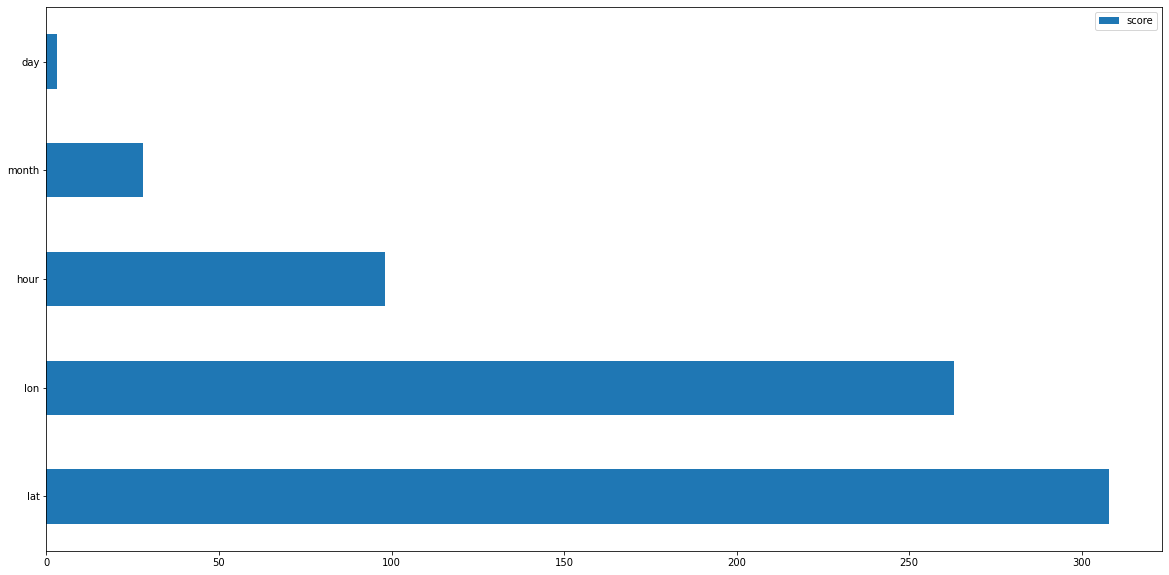

In [ ]:
feature_importants = baseline_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importants.keys())
values = list(feature_importants.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

In [ ]:
# Что делаем там где инфы
# Интерактивная карта по значениям - https://geohackweek.github.io/ghw2018_web_portal_inlandwater_co2/InteractiveTimeSeries.html
# Не хватает мета инфы прошлого
# Видно переобучение + возможно работали с ликами

### Attempt 2
* Убрать лик времени
* Добавить мета инфу (прошлый предикт + инфо лайков/эмоций/и т.д.)

In [ ]:
short_train = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/nice_train_on_baseline.csv')
short_train = short_train[['lat', 'lon', 'hour', 'day', 'month','publication','date']]

valid = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/valid.csv')

out_of_sample = valid.copy().rename(columns={'sum':'publication'})

out_of_sample['date'] = pd.to_datetime(out_of_sample['hour'], unit='s')
out_of_sample['hour'] = out_of_sample['date'].apply(lambda x: x.hour)
out_of_sample['day'] = out_of_sample['date'].apply(lambda x: x.day)
out_of_sample['month'] = out_of_sample['date'].apply(lambda x: x.month)

out_of_sample = out_of_sample[['lat', 'lon', 'hour', 'day', 'month','publication','date']]

In [ ]:
import holidays
import datetime
russian_holidays = list(holidays.Russia(years=2019))+list(holidays.Russia(years=2020))+[datetime.date(2019, 2, 14),datetime.date(2019, 4, 28),datetime.date(2020, 2, 14)]

In [ ]:
russian_holidays = pd.DataFrame(russian_holidays, columns=['short_date'])
russian_holidays['holiday'] = 1
russian_holidays['short_date'] = pd.to_datetime(russian_holidays['short_date'])

# джойн праздников
short_train['short_date'] = pd.to_datetime(short_train['date'])
short_train = short_train.merge(russian_holidays, on='short_date', how='left').fillna(0)

# выходной
short_train['weekend'] = short_train['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

# season
short_train['season'] = short_train['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

In [ ]:
short_train.date.min()

'2019-01-01 00:00:00'

In [ ]:
short_train.date.max()

'2020-01-31 23:00:00'

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
spark.stop()

In [ ]:
import findspark
import pyspark

from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import HiveContext

findspark.init()
# create the session
conf = pyspark.SparkConf()
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
lagged_train = pd.read_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/lagged_train')

In [ ]:
lagged_spark_train = spark.createDataFrame(lagged_train)

win_2h = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*2, 0)
win_6h = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*6, 0)
win_1d = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*24, 0)
win_7d = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*24*7, 0)

lagged_spark_train = lagged_spark_train\
                        .withColumn('pub_ma_2h', F.avg('publication').over(win_2h))\
                        .withColumn('pub_ma_6h', F.avg('publication').over(win_6h))\
                        .withColumn('pub_ma_1d', F.avg('publication').over(win_1d))\
                        .withColumn('pub_ma_7d', F.avg('publication').over(win_7d))

In [ ]:
lagged_spark_train.count()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
new_df = lagged_spark_train.toPandas()

In [ ]:
short_train['timestamp'] = short_train['short_date'].values.astype(np.int64) // 10 ** 9

In [ ]:
def join_lags(short_train, lag_time: int, name: str):
  joined_df = short_train.copy()[['lat', 'lon', 'timestamp', 'publication']]
  joined_df.columns = ['lat', 'lon', 'timestamp', 'publication_{}'.format(name)]
  joined_df['timestamp'] = joined_df['timestamp']-(3600*lag_time)

  short_train = short_train.merge(joined_df, on=['lat', 'lon', 'timestamp'], how='left')
  return short_train

In [ ]:
lagged_train = join_lags(short_train, 1, '1h')
lagged_train = join_lags(lagged_train, 2, '2h')
lagged_train = join_lags(lagged_train, 3, '3h')
lagged_train = join_lags(lagged_train, 4, '4h')
lagged_train = join_lags(lagged_train, 24*1, '1d')
lagged_train = join_lags(lagged_train, 24*2, '2d')
lagged_train = join_lags(lagged_train, 24*3, '3d')
lagged_train = join_lags(lagged_train, 24*4, '4d')

In [ ]:
lagged_train.to_csv('/content/drive/MyDrive/Datasets/industrial ml itmo/lagged_train', index=False)

In [ ]:
short_lagged_train = lagged_train[['lat', 'lon', 'hour', 'day', 'month', 'publication', 'holiday', 'weekend', 'season',
       'publication_1h', 'publication_2h', 'publication_3h', 'publication_4h',
       'publication_1d', 'publication_2d', 'publication_3d', 'publication_4d']]

In [ ]:
trainset, validset = short_lagged_train.query('month<11'), short_lagged_train.query('month>=11')

In [ ]:
X_train, y_train, X_valid, y_valid = trainset.drop(['publication'], 1), trainset['publication'], validset.drop(['publication'], 1), validset['publication']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
out_of_sample = valid.copy().rename(columns={'sum':'publication'})

out_of_sample['date'] = pd.to_datetime(out_of_sample['hour'], unit='s')
out_of_sample['hour'] = out_of_sample['date'].apply(lambda x: x.hour)
out_of_sample['day'] = out_of_sample['date'].apply(lambda x: x.day)
out_of_sample['month'] = out_of_sample['date'].apply(lambda x: x.month)

russian_holidays = pd.DataFrame(russian_holidays, columns=['short_date'])
russian_holidays['holiday'] = 1
russian_holidays['short_date'] = pd.to_datetime(russian_holidays['short_date'])

# джойн праздников
out_of_sample['short_date'] = pd.to_datetime(out_of_sample['date'])
out_of_sample = out_of_sample.merge(russian_holidays, on='short_date', how='left').fillna(0)

# выходной
out_of_sample['weekend'] = out_of_sample['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

# season
out_of_sample['season'] = out_of_sample['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

# timestamp
out_of_sample['timestamp'] = out_of_sample['short_date'].values.astype(np.int64) // 10 ** 9

lagged_out_of_sample = join_lags(out_of_sample, 1, '1h')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 2, '2h')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 3, '3h')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 4, '4h')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 24*1, '1d')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 24*2, '2d')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 24*3, '3d')
lagged_out_of_sample = join_lags(lagged_out_of_sample, 24*4, '4d')

lagged_out_of_sample = lagged_out_of_sample[['lat', 'lon', 'hour', 'day', 'month', 'publication', 'holiday', 'weekend', 'season',
       'publication_1h', 'publication_2h', 'publication_3h', 'publication_4h',
       'publication_1d', 'publication_2d', 'publication_3d', 'publication_4d']]

lagged_out_of_sample_spark = spark.createDataFrame(lagged_out_of_sample)

win_2h = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*2, 0)
win_6h = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*6, 0)
win_1d = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*24, 0)
win_7d = Window.partitionBy('lat', 'lon').orderBy('timestamp').rangeBetween(-3600*24*7, 0)

lagged_out_of_sample_spark = lagged_out_of_sample_spark\
                        .withColumn('pub_ma_2h', F.avg('publication').over(win_2h))\
                        .withColumn('pub_ma_6h', F.avg('publication').over(win_6h))\
                        .withColumn('pub_ma_1d', F.avg('publication').over(win_1d))\
                        .withColumn('pub_ma_7d', F.avg('publication').over(win_7d))

lagged_out_of_sample = lagged_out_of_sample_spark.toPandas()

X_test, y_test = lagged_out_of_sample.drop(['publication'],1), lagged_out_of_sample.publication

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
new_df

In [ ]:
def custom_loss(true_val, pred_val):
  return abs(pred_val-true_val)/pred_val

In [ ]:
def custom_loss(true_val, pred_val):
  return abs(pred_val-true_val)/pred_val

baseline_model = XGBRegressor(max_depth=2)
baseline_model.fit(short_lagged_train.drop(['publication'], 1), short_lagged_train['publication'])

train_preds = baseline_model.predict(short_lagged_train.drop(['publication'], 1))
test_preds = baseline_model.predict(X_test)

print(i)
print('TRAIN: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(short_lagged_train['publication'], train_preds),
                                                        mse(short_lagged_train['publication'], train_preds),
                                                        r2(short_lagged_train['publication'], train_preds),
                                                        np.mean(custom_loss(short_lagged_train['publication'], train_preds))))

print('TEST: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_test, test_preds),
                                                        mse(y_test, test_preds),
                                                        r2(y_test, test_preds),
                                                        np.mean(custom_loss(y_test, test_preds))))

In [ ]:
print('TRAIN: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(short_lagged_train['publication'], train_preds),
                                                         mse(short_lagged_train['publication'], train_preds),
                                                         r2(short_lagged_train['publication'], train_preds),
                                                         np.mean(custom_loss(short_lagged_train['publication'], train_preds))))

# print('VALID: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_valid, valid_preds),
#                                                          mse(y_valid, valid_preds),
#                                                          r2(y_valid, valid_preds),
#                                                          np.mean(custom_loss(y_valid, valid_preds))))

print('TEST: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_test, test_preds),
                                                         mse(y_test, test_preds),
                                                         r2(y_test, test_preds),
                                                         np.mean(custom_loss(y_test, test_preds))))

TRAIN: mae 0.8928225230573947, mse 3.3214890140284057, r2 0.8080223648469842, custom_loss 0.3783109486103058
TEST: mae 8.54157285461641, mse 113.08917944008071, r2 -1.7581009731464121, custom_loss 6.772681489490689


In [ ]:
short_lagged_train[['lat', 'lon']].drop_duplicates().count()

lat    7025
lon    7025
dtype: int64

In [ ]:
valid[['lat', 'lon']].drop_duplicates().count()

lat    155
lon    155
dtype: int64

In [ ]:
common_coords = short_lagged_train[['lat', 'lon']].drop_duplicates().merge(valid[['lat', 'lon']].drop_duplicates(), on=['lat', 'lon'], how='inner')[['lat', 'lon']]

In [ ]:
# не хватает инфы о местоположении
# valid coords change

In [ ]:
common_valid = valid.merge(common_coords, on=['lat', 'lon'], how='inner')

In [ ]:
common_valid[common_valid['sum']==0]

,hour,lat,lon,point,sum,error,baseline_pred,baseline_error


In [ ]:
print('COMMON TEST: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(common_valid['sum'], common_valid.baseline_pred),
                                                         mse(common_valid['sum'], common_valid.baseline_pred),
                                                         r2(common_valid['sum'], common_valid.baseline_pred),
                                                         np.mean(custom_loss(common_valid['sum'], common_valid.baseline_pred))))

COMMON TEST: mae 7.982173535558912, mse 102.92062265405588, r2 -1.6105606301988629, custom_loss 6.66068394184244


In [ ]:
valid['baseline_pred'] = test_preds
valid['baseline_error'] = custom_loss(y_test, test_preds)
valid.sort_values('baseline_pred', ascending=False).head(20)

,hour,lat,lon,point,sum,error,baseline_pred,baseline_error
241,1581667200,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,24,10.754735,12.856146,0.866811
684,1582380000,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,17,1.048732,5.105500,2.329743
200,1581260400,59.938238,30.331616,0101000020E61000009BAC04C2E4543E40CEB8CE2B18F8...,9,0.120265,4.802864,0.873882
129,1581264000,59.938238,30.331616,0101000020E61000009BAC04C2E4543E40CEB8CE2B18F8...,9,0.254735,4.212362,1.136569
252,1582218000,59.966350,30.311403,0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...,8,0.088069,3.736856,1.140837
434,1581418800,59.921359,30.468609,0101000020E6100000199C86BCF6773E401FBF4913EFF5...,14,0.754735,3.286350,3.260045
501,1582304400,59.928111,30.360811,0101000020E61000004D98FA185E5C3E40D4F7F058CCF6...,20,2.088069,3.286249,5.085966
540,1581156000,0.000000,0.000000,0101000020E61000000000000000000000000000000000...,5,0.620265,3.233872,0.546134
585,1580756400,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,22,2.421402,3.187868,5.901164
63,1581253200,59.931487,30.354073,0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...,17,3.004735,3.066342,4.544066


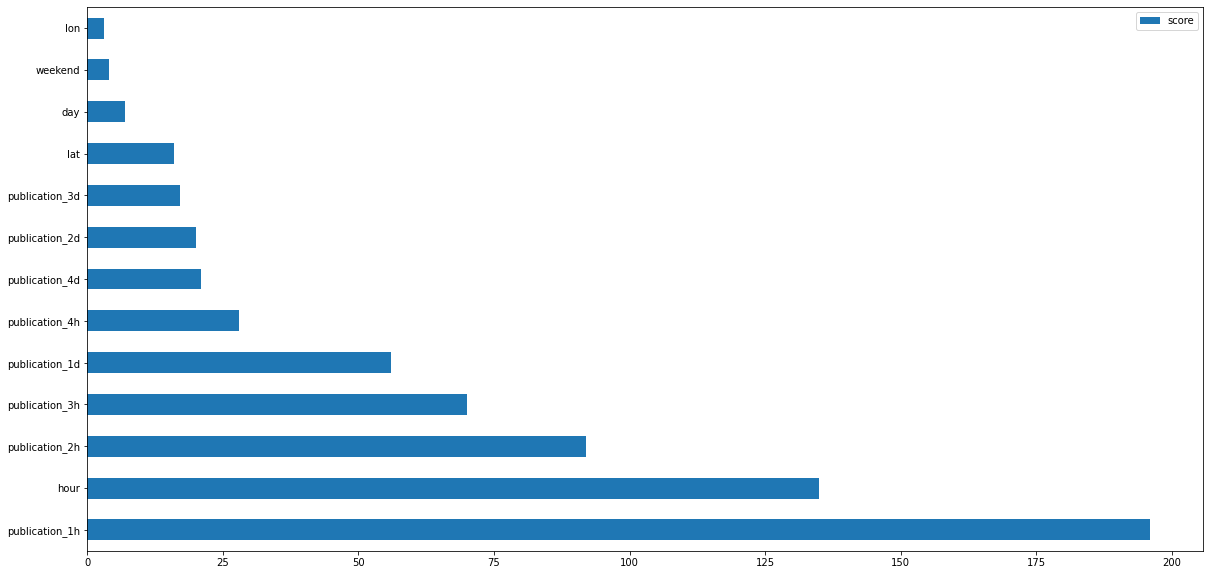

In [ ]:
feature_importants = baseline_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importants.keys())
values = list(feature_importants.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))